## **Face Recognition**

**Facial Recognition System** is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services, works by pinpointing and measuring facial features from a given image. 

We'll be building a face recognition model that uses **Siamese Networks** to give us a distance value that indicates whether 2 images are same or different. 

#### **The Dataset**
We'll be using the **Extracted Faces** from **face-recognition-dataset**, which is derived from the **LFW Dataset**.
The Extracted Faces contains faces extracted from the base images using **Haar-Cascade Face-Detection** (CV2).
- The dataset contains 1324 different individuals, with 2-50 images per person.
- The images are of size (128,128,3) and are encoded in RGB.
- Each folder and image is named with a number, i.e 0.jpg, 1.jpg

## **Reading the Dataset**

We're reading the folders and splitting them into **train and test set** for training purposes.

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
tf.__version__, np.__version__

In [4]:
path = '../Dataset_Siamese'
list_dirs = os.listdir(path)

def create_generator_dataset(list_dirs, maxfiles = 20):
    list_path_images = []
    for dir in list_dirs:
        new_path = os.path.join(path, dir)
        images = os.listdir(new_path)[:maxfiles]
        num_images = len(images)
        if num_images >= 2:
            for i in range(num_images - 1):
                for j in range(i +1, num_images):

                    anchor = os.path.join(new_path, images[i])
                    positive = os.path.join(new_path, images[j])

                    count = 0
                    while count < 1:
                        negative_dir = dir
                        while negative_dir == dir:
                            negative_dir = random.choice(list_dirs)

                        negative_images = os.listdir(f'{path}/{negative_dir}')
                        negative_image = random.choice(negative_images)
                        negative_dir = os.path.join(path, negative_dir)
                        negative = os.path.join(negative_dir, negative_image)
                        count +=1

                        list_path_images.append([positive, anchor, negative])

    random.shuffle(list_path_images)
    return list_path_images

In [36]:
triplet_dataset = create_generator_dataset(list_dirs)

### Creating Triplets

We use the train and test list to create triplets of **(anchor, postive, negative)** face data, where positive is the same person and negative is a different person than anchor.

In [5]:
def process_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def split_data(list_file, ratio):
    if ratio[0] + ratio[1] + ratio[2] != 1:
        print('total ratio must equal 1')
        return
    else:
        train = int(len(list_file)* ratio[0])
        val = int(len(list_file)* ratio[1])

    return list_file[:train], list_file[train: (train + val)], list_file[(train + val):]

In [37]:
train, val, test = split_data(triplet_dataset, [0.8, 0.1, 0.1])
print(len(train))
print(len(val))
print(len(test))

21920
2740
2740


### Creating Batch-Generator

Creating a **Batch-Generator** that converts the triplets passed into batches of face-data and **preproccesses** it before returning the data into seperate lists.

**Parameters:**
- Batch_size: Batch_size of the data to return
- Preprocess: Whether to preprocess the data or not

In [38]:
def generate_batch_dataset(list_files, batch_size = 64, preprocess = True):
    num_batch = len(list_files)// batch_size

    for i in range(num_batch + 1):
        anchor = []
        positive = []
        negative = []
        j = i*batch_size

        while j < (i+1) * batch_size and j < len(list_files):
            a, p, n = list_files[j]

            anchor.append(process_image(a))
            positive.append(process_image(p))
            negative.append(process_image(n))

            j+=1
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
    
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
    
        yield ([positive, anchor, negative])

In [39]:
train_generator = generate_batch_dataset(train, batch_size = 128)
val_generator = generate_batch_dataset(val, batch_size = 128)
test_generator = generate_batch_dataset(test, batch_size = 16)

### Plotting the Data

Plotting the data generated from **get_batch()** to see the results

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in train_generator:
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        break


## **Creating the Model**

Unlike a conventional CNN, the **Siamese Network** does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

![Siamese Network Image](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Lambda, Input, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from tensorflow.keras import backend, layers, metrics


In [9]:
class Distance(tf.keras.layers.Layer):
    def __init__(self, **kwarg):
        super().__init__(**kwarg)

    def call(self,anchor, positive, negative):
        d_pos = tf.reduce_sum(tf.square(positive - anchor), -1)
        d_neg = tf.reduce_sum(tf.square(negative - anchor), -1)
        return (d_pos, d_neg)



In [10]:
def encoder(input_shape):
    base_cnn = ResNet50(
        weights="imagenet", input_shape= input_shape, include_top=False, pooling='avg',
    )
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
        
    encode_model = Sequential([
    base_cnn,
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))
  ])
    
    return encode_model

In [11]:
def final_model(input_shape = (150, 125, 3) ):
    
    encode = encoder(input_shape)

    input_a = Input(input_shape, name = 'input_anchor')
    input_p = Input(input_shape, name = 'input_positive')
    input_n = Input(input_shape, name = 'input_negative')

    feature_a = encode(input_a)
    feature_p = encode(input_p)
    feature_n = encode(input_n)

    distances = Distance()(
      feature_a,
      feature_p,
      feature_n
    )

    model = Model(inputs = [input_a, input_p, input_n], outputs = distances)
    return model

In [14]:
siamese_network = final_model()

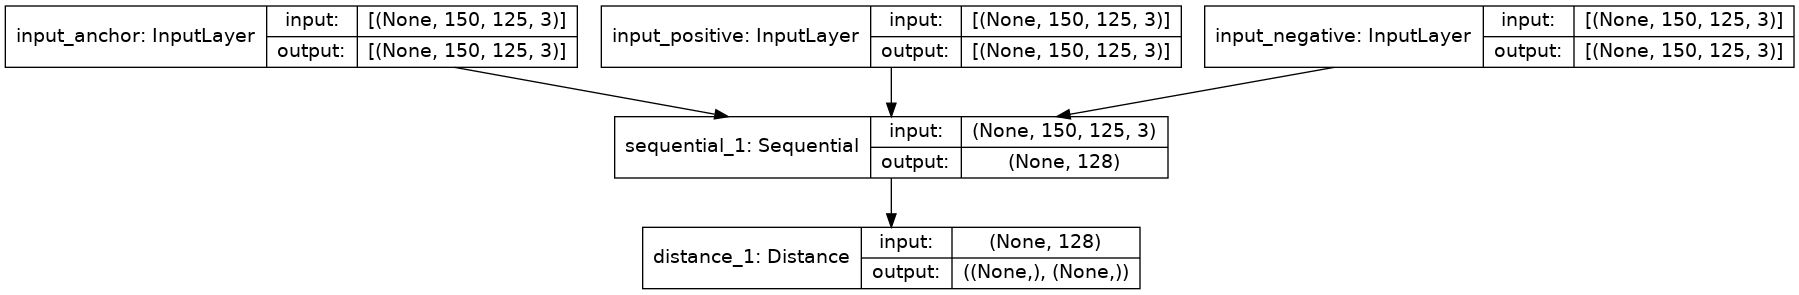

In [15]:
tf.keras.utils.plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [17]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [21]:
siamese_model = SiameseModel(siamese_network)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [22]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in generate_batch_dataset(val, batch_size = 128):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [40]:
import time
save_all = False
epochs = 30
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in generate_batch_dataset(train, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    


EPOCH: 1 	 (Epoch done in 237 sec)
Loss on train    = 0.28139
Accuracy on test = 0.93321

EPOCH: 2 	 (Epoch done in 232 sec)
Loss on train    = 0.16407
Accuracy on test = 0.96022

EPOCH: 3 	 (Epoch done in 211 sec)
Loss on train    = 0.10840
Accuracy on test = 0.95985

EPOCH: 4 	 (Epoch done in 210 sec)
Loss on train    = 0.07694
Accuracy on test = 0.96825

EPOCH: 5 	 (Epoch done in 216 sec)
Loss on train    = 0.05396
Accuracy on test = 0.97080

EPOCH: 6 	 (Epoch done in 231 sec)
Loss on train    = 0.04526
Accuracy on test = 0.97263

EPOCH: 7 	 (Epoch done in 216 sec)
Loss on train    = 0.03378
Accuracy on test = 0.98212

EPOCH: 8 	 (Epoch done in 211 sec)
Loss on train    = 0.02552
Accuracy on test = 0.97774

EPOCH: 9 	 (Epoch done in 222 sec)
Loss on train    = 0.02200
Accuracy on test = 0.98285

EPOCH: 10 	 (Epoch done in 197 sec)
Loss on train    = 0.01798
Accuracy on test = 0.98431

EPOCH: 11 	 (Epoch done in 215 sec)
Loss on train    = 0.01292
Accuracy on test = 0.97883

EPOCH: 

In [49]:
def extract_encoder(model):
    ec = encoder((150, 125, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        ec.layers[i].set_weights(layer_weight)
        i+=1
    return ec

encode = extract_encoder(siamese_model)
encode.save("../Model/feature_extractor")
encode.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
lambda_5 (Lambda)            (None, 128)               0         
Total params: 24,146,176
Trainable params: 9,489,280
Non-trainable params: 14,656,896
_________________________________________________________________


## References

- FaceNet: A Unified Embedding for Face Recognition and Clustering: https://arxiv.org/abs/1503.03832
- Image similarity estimation using a Siamese Network with a triplet loss: https://keras.io/examples/vision/siamese_network/
- Celebrity Face Recognition: https://www.kaggle.com/ravehgillmore/celebrity-face-recognition/
- Face Recognition using Siamese Networks: https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4
